In [ ]:
import cv2 as cv
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageOps
from matplotlib import pyplot as plt
from skimage import filters
from skimage.feature import corner_peaks
from scipy.ndimage.filters import convolve
from sklearn.cluster import KMeans
from skimage.transform import hough_line, hough_line_peaks
from dotenv import load_dotenv
import os

load_dotenv() 
data_folder = os.getenv("DATA_PATH")

/var/folders/jt/6mkq9j615zd1zpwbt9x4bsfw0000gn/T/ipykernel_76328/3133078312.py:8: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [ ]:
# Set seed
np.random.seed(20)

(3024, 4032)


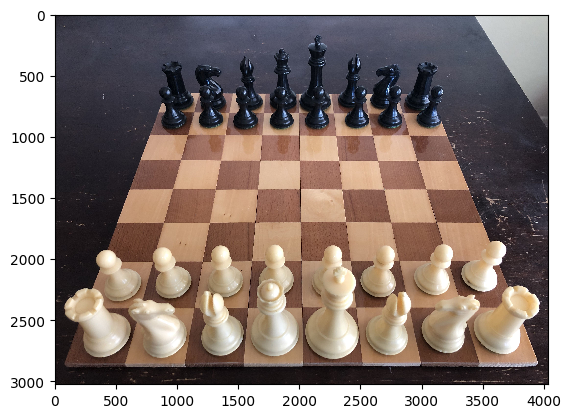

In [ ]:
# Load Image
path = os.path.join(data_folder, 'examplechessboard.jpeg')
data = Image.open(path)
image = np.array(data)
board = np.array(ImageOps.grayscale(data))
print(board.shape)
plt.imshow(image, interpolation='nearest')
plt.show()

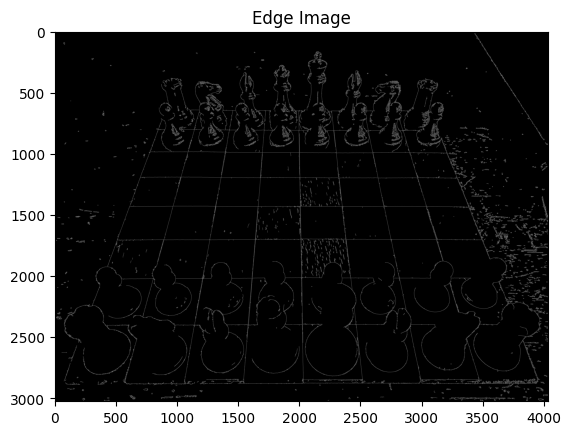

In [ ]:
# Edge Detection

low_threshold = 50
high_threshold = 150
edges = cv.Canny(board, low_threshold, high_threshold)
plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image')
plt.show()

In [ ]:
# Below is code I wrote but is adapted from a past personal project of mine

# Find a series of horizontal lines on the image
houghBoard = [[10, 100, 16], [10, 100, 16]]
def getHoriLines(image):
    test_angles = np.linspace(np.pi / 1.5, np.pi / 2.5, 90)
    hspace, theta, dist = hough_line(image, test_angles)
    h, q, d = hough_line_peaks(hspace, theta, dist, min_distance=houghBoard[0][0], threshold=houghBoard[0][1], num_peaks=houghBoard[0][2])
    lines = [[q[i], d[i]] for i in range(q.shape[0])]
    point_slope_form = []
    for ang, len in lines:
        point = len * np.array([np.cos(ang), np.sin(ang)])
        slope = np.tan(ang + (np.pi / 2))
        point_slope_form.append([point, slope])
    return point_slope_form


# Find a series of vertical lines on the image
def getVertLines(image):
    test_angles = np.linspace(-np.pi / 6, np.pi / 6, 90)
    hspace, theta, dist = hough_line(image, test_angles)
    h, q, d = hough_line_peaks(hspace, theta, dist, min_distance=houghBoard[1][0], threshold=houghBoard[1][1], num_peaks=houghBoard[1][2])
    lines = [[q[i], d[i]] for i in range(q.shape[0])]
    point_slope_form = []
    for ang, len in lines:
        point = len * np.array([np.cos(ang), np.sin(ang)])
        slope = np.tan(ang + (np.pi / 2))
        point_slope_form.append([point, slope])
    return point_slope_form

In [ ]:
def plotLines(lines, image):
  for (point, slope) in lines:  plt.axline(point, slope=slope)
  plt.imshow(image)

<ipython-input-100-8e36c908b3c8>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  hL = np.array(getHoriLines(edges))
<ipython-input-100-8e36c908b3c8>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  vL = np.array(getVertLines(edges))


(16, 2) (16, 2)


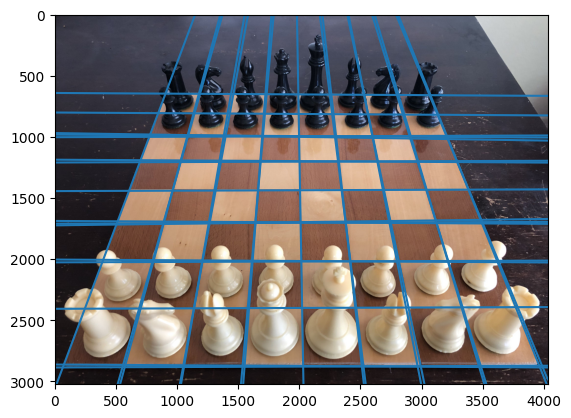

In [ ]:
# Note we sort  the horizontal lines by y intercept and the vertical by the x intercept
hL = np.array(getHoriLines(edges))
vL = np.array(getVertLines(edges))
print(hL.shape, vL.shape)
plotLines(hL, data)
plotLines(vL, data)
plt.show()

In [ ]:
# Trim the lines
y_inter = np.array([x[0][1] - (x[1] * x[0][0]) for x in hL])[:, np.newaxis]
x_inter = np.array([-(x[0][1] - (x[1] * x[0][0])) / x[1] for x in vL])[:, np.newaxis]
y_kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto").fit(y_inter.copy())
x_kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto").fit(x_inter.copy())

9 9


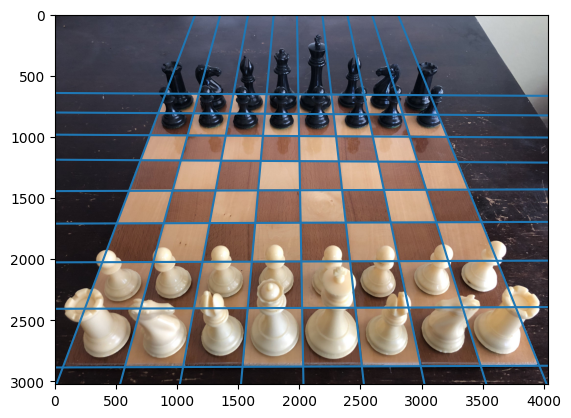

In [ ]:
# Better way to do this is to find the best match for the centriod instead of the first
# However the code below does just fine in this case
H, V = [None] * 9, [None] * 9
for i, y, in enumerate(y_inter):
  indx = y_kmeans.predict([y])[0]
  if H[indx] is None: H[indx] = hL[i]
for i, x, in enumerate(x_inter):
  indx = x_kmeans.predict([x])[0]
  if V[indx] is None: V[indx] = vL[i]

H = sorted(H, key=lambda x: x[0][1] - (x[1] * x[0][0]))
V = sorted(V, key=lambda x: -(x[0][1] - (x[1] * x[0][0])) / x[1])
print(len(H), len(V))
plotLines(H, data)
plotLines(V, data)
plt.show()


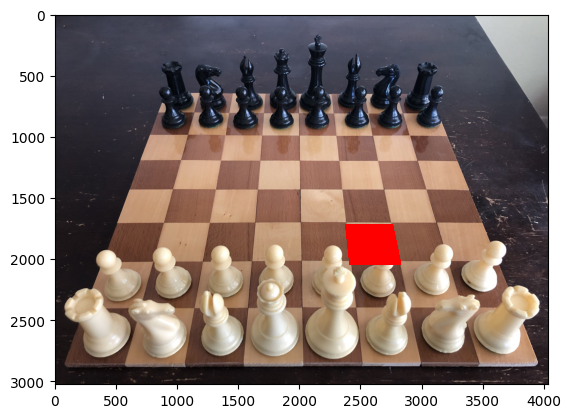

In [ ]:
# Plot a square
def highlightTile(grid_x, grid_y, H, V, image, color):
    top, bottom, left, right = H[grid_y], H[grid_y + 1], V[grid_x], V[grid_x + 1]
    y_indices, x_indices = np.indices(image.shape[:2])

    condition_top = top[1] * (x_indices - top[0][0]) >= top[0][1] - y_indices
    condition_bottom = bottom[1] * (x_indices - bottom[0][0]) <= bottom[0][1] - y_indices

    condition_left = None
    if left[1] >= 0:  condition_left = -left[1] * (x_indices - left[0][0]) <= left[0][1] - y_indices
    else: condition_left = -left[1] * (x_indices - left[0][0]) >= left[0][1] - y_indices
    condition_right = None
    if right[1] >= 0: condition_right = -right[1] * (x_indices - right[0][0]) >= right[0][1] - y_indices
    else: condition_right = -right[1] * (x_indices - right[0][0]) <= right[0][1] - y_indices
    inside_tile = condition_top & condition_bottom & condition_left & condition_right

    yv, xv = np.where(inside_tile)
    plt.scatter(xv, yv, c=color, s=1)


highlightTile(5, 5, H, V, board, "red")
plt.imshow(data)
plt.show()

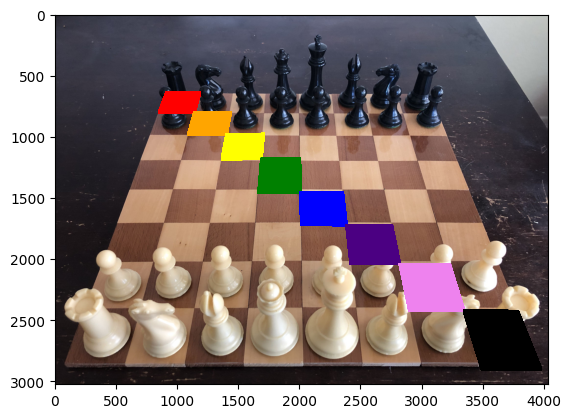

In [ ]:
# For fun let us highlight the diagonal
colors = ["red", "orange", "yellow", "green", "blue", "indigo", "violet", "black"]
for i in range(8):
  highlightTile(i, i, H, V, board, colors[i])
plt.imshow(data)
plt.show()